## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
from keras.regularizers import l2
import matplotlib.pyplot as plt
import io
from PIL import Image
from keras.utils import to_categorical
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3

## Data Loading and Preprocessing

In [2]:
data_dir = "/kaggle/input/brain-tumor-classification-mri/Training"
test_data_dir = '/kaggle/input/brain-tumor-classification-mri/Testing'

class_names = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

def load_data(data_directory):
    images = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(class_dir, filename)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(class_idx)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load the data
X, y = load_data(data_dir)
X_test, y_test = load_data(test_data_dir)

# Normalize the pixel values
X = X / 255.0
X_test = X_test / 255.0
# Convert class vectors to binary class matrices
y = to_categorical(y, num_classes=len(class_names))

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.6, random_state=69)

# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare iterators
train_gen = data_gen.flow(X_train, y_train, batch_size=32)
val_gen = data_gen.flow(X_val, y_val, batch_size=32)

## Image Morphing for Ensemble Learning

In [90]:
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import feature, morphology
from keras.preprocessing.image import ImageDataGenerator

X_hog = np.array([feature.hog(img, block_norm='L2-Hys', visualize=False) for img in X])
X_morph = np.array([morphology.binary_erosion(img) for img in X])

In [95]:
def preprocess(X):
    X_morph = np.array([morphology.binary_erosion(img) for img in X])
    X_combined = np.concatenate([X, X_morph], axis=-1)
    return X_combined[:,:,:,:3],X_combined[:,:,:,3:]

X_test_1, X_test_2 = preprocess(X_test)

In [96]:
# Concatenate the original images with the extracted features
X_combined = np.concatenate([X, X_morph], axis=-1)

In [97]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare iterators
train_gen = data_gen.flow(X_train, y_train, batch_size=32)
val_gen = data_gen.flow(X_val, y_val, batch_size=32)

In [98]:
from skimage import feature, morphology
from keras.preprocessing.image import ImageDataGenerator

X_hog = np.array([feature.hog(img, block_norm='L2-Hys', visualize=False) for img in X])
X_morph = np.array([morphology.binary_erosion(img) for img in X])

X_combined = np.concatenate([X, X_morph], axis=-1)

X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [99]:
X_train_1,X_train_2 = X_train[:,:,:,:3],X_train[:,:,:,3:]
X_val_1,X_val_2 = X_val[:,:,:,:3],X_val[:,:,:,3:]

data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = data_gen.flow(X_train_1, y_train, batch_size=32)
val_gen = data_gen.flow(X_val_1, y_val, batch_size=32)

## Baseline Model

In [4]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax'),
])

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [5]:
# Define a callback to prevent overfitting
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
]

# Train the model
history = model_1.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Epoch 1/30
36/36 [==============================] - 35s 839ms/step - loss: 1.4130 - accuracy: 0.3744 - val_loss: 1.2569 - val_accuracy: 0.4210
Epoch 2/30
36/36 [==============================] - 28s 780ms/step - loss: 1.2659 - accuracy: 0.4289 - val_loss: 1.1546 - val_accuracy: 0.4715
Epoch 3/30
36/36 [==============================] - 28s 785ms/step - loss: 1.1980 - accuracy: 0.4591 - val_loss: 1.0409 - val_accuracy: 0.5720
Epoch 4/30
36/36 [==============================] - 28s 778ms/step - loss: 1.0818 - accuracy: 0.5436 - val_loss: 1.0204 - val_accuracy: 0.5215
Epoch 5/30
36/36 [==============================] - 28s 793ms/step - loss: 0.9704 - accuracy: 0.5662 - val_loss: 0.8427 - val_accuracy: 0.6260
Epoch 6/30
36/36 [==============================] - 28s 777ms/step - loss: 0.8806 - accuracy: 0.6126 - val_loss: 0.8217 - val_accuracy: 0.6434
Epoch 7/30
36/36 [==============================] - 28s 781ms/step - loss: 0.8532 - accuracy: 0.6550 - val_loss: 0.7694 - val_accuracy: 0.6852

### Plots

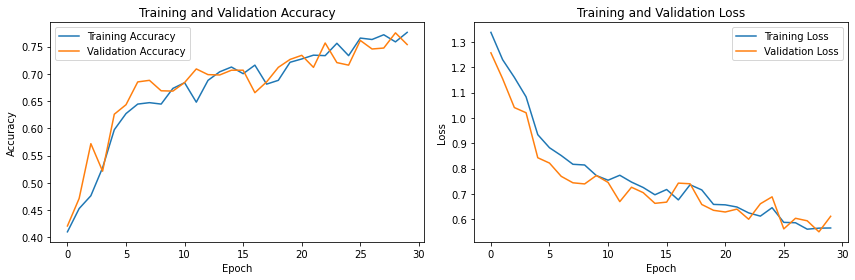

In [6]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy

In [7]:
# Predict the labels for the training set
y_train_pred = model_1.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true_labels, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred = model_1.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Training Accuracy: 83.36%
Validation Accuracy: 77.82%


In [9]:
# Predict the labels for the training set
y_test_pred = model_1.predict(X_test)

# Convert the predicted probabilities to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
# y_test_true_labels = np.argmax(y_test, axis=1)

# Calculate training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

Testing Accuracy: 41.12%


### Confusion Matrix

In [10]:
# Generate predictions
y_pred_probs = model_1.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

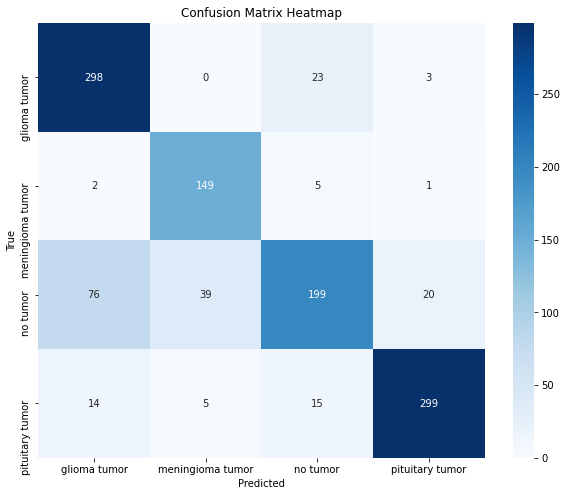

In [11]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification Report

In [12]:
model_pred = model_1.predict(X_test)

In [13]:
from sklearn.metrics import classification_report

report = classification_report(y_test, np.argmax(model_pred, axis=1))

print(report)

              precision    recall  f1-score   support

           0       0.77      0.17      0.28       100
           1       0.32      0.93      0.47       105
           2       0.52      0.15      0.23       115
           3       0.73      0.30      0.42        74

    accuracy                           0.39       394
   macro avg       0.58      0.39      0.35       394
weighted avg       0.57      0.39      0.34       394



## Baseline Updated Model

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1_update = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Added dropout layer

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),  # Added dropout layer

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Reduced neurons and added L2 regularization
    Dropout(0.5),

    Dense(len(class_names), activation='softmax'),
])

model_1_update.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model_1_update.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)       

In [16]:
# Define a callback to prevent overfitting
callbacks_1_updated = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
]

# Train the model
history_1_updated = model_1_update.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Epoch 1/30
36/36 [==============================] - 29s 795ms/step - loss: 8.6626 - accuracy: 0.3373 - val_loss: 34.3120 - val_accuracy: 0.3043
Epoch 2/30
36/36 [==============================] - 28s 786ms/step - loss: 1.6402 - accuracy: 0.3340 - val_loss: 42.6463 - val_accuracy: 0.2915
Epoch 3/30
36/36 [==============================] - 28s 786ms/step - loss: 1.6792 - accuracy: 0.3654 - val_loss: 27.7406 - val_accuracy: 0.2927
Epoch 4/30
36/36 [==============================] - 28s 781ms/step - loss: 1.6020 - accuracy: 0.3909 - val_loss: 16.3794 - val_accuracy: 0.2997
Epoch 5/30
36/36 [==============================] - 28s 794ms/step - loss: 1.6090 - accuracy: 0.3833 - val_loss: 7.3661 - val_accuracy: 0.3397
Epoch 6/30
36/36 [==============================] - 28s 790ms/step - loss: 1.5679 - accuracy: 0.3756 - val_loss: 4.6812 - val_accuracy: 0.3891
Epoch 7/30
36/36 [==============================] - 28s 785ms/step - loss: 1.5794 - accuracy: 0.3822 - val_loss: 6.0297 - val_accuracy: 0.

### Plots

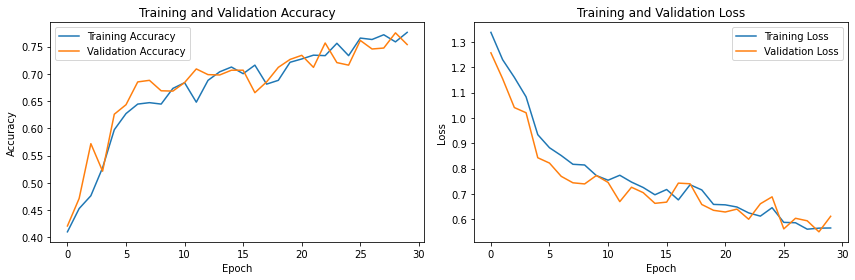

In [17]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy

In [19]:
# Predict the labels for the training set
y_train_pred_1_updated = model_1_update.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels_1_updated = np.argmax(y_train_pred_1_updated, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy_1_updated = accuracy_score(y_train_true_labels, y_train_pred_labels_1_updated)
print(f'Training Accuracy: {train_accuracy_1_updated * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred_1_updated = model_1_update.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels_1_updated = np.argmax(y_val_pred_1_updated, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy_1_updated = accuracy_score(y_val_true_labels, y_val_pred_labels_1_updated)
print(f'Validation Accuracy: {val_accuracy_1_updated * 100:.2f}%')


Training Accuracy: 54.97%
Validation Accuracy: 51.80%


In [20]:
# Predict the labels for the training set
y_test_pred = model_1_update.predict(X_test)

# Convert the predicted probabilities to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
# y_test_true_labels = np.argmax(y_test, axis=1)

# Calculate training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

Testing Accuracy: 29.70%


### Confusion Matrix

In [21]:
# Generate predictions
y_pred_probs = model_1_update.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

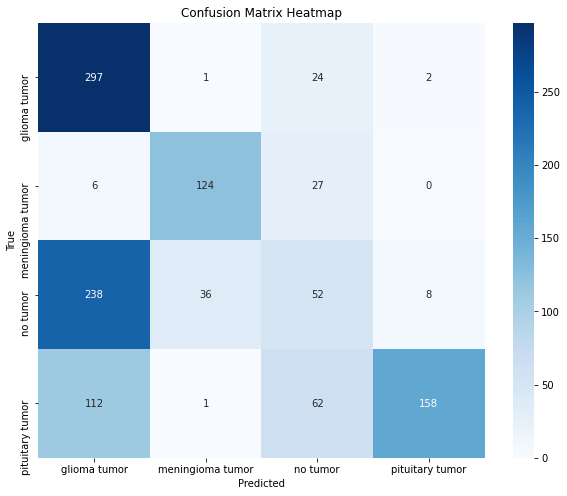

In [22]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification Report

In [23]:
model_pred = model_1_update.predict(X_test)

In [24]:
from sklearn.metrics import classification_report

report = classification_report(y_test, np.argmax(model_pred, axis=1))

print(report)

              precision    recall  f1-score   support

           0       0.47      0.23      0.31       100
           1       0.28      0.64      0.39       105
           2       0.24      0.22      0.23       115
           3       0.50      0.03      0.05        74

    accuracy                           0.30       394
   macro avg       0.37      0.28      0.25       394
weighted avg       0.36      0.30      0.26       394



## LeNet

In [26]:
# Define the LeNet-5 architecture
model_1_LeNet = Sequential([
    Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(224, 224, 3)),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(units=120, activation='tanh'),
    Dense(units=84, activation='tanh'),
    Dense(units=len(class_names), activation='softmax')
])

# Compile the model
model_1_LeNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_1_LeNet.summary()

# Define a callback for early stopping
callbacks_1 = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

# Train the model
history_1 = model_1_LeNet.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 220, 220, 6)       456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 110, 110, 6)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 106, 106, 16)      2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 44944)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               5393400   
_________________________________________________________________
dense_8 (Dense)              (None, 84)               

### Plots

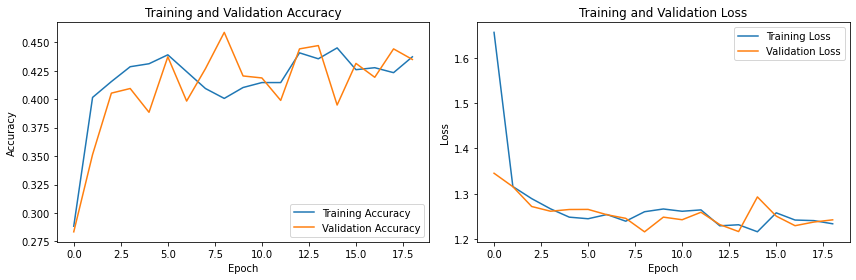

In [27]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy

In [28]:
# Predict the labels for the training set
y_train_pred_1 = model_1_LeNet.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels_1 = np.argmax(y_train_pred_1, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy_1 = accuracy_score(y_train_true_labels, y_train_pred_labels_1)
print(f'Training Accuracy: {train_accuracy_1 * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred_1 = model_1_LeNet.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels_1 = np.argmax(y_val_pred_1, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy_1 = accuracy_score(y_val_true_labels, y_val_pred_labels_1)
print(f'Validation Accuracy: {val_accuracy_1 * 100:.2f}%')


Training Accuracy: 43.55%
Validation Accuracy: 45.53%


In [29]:
# Predict the labels for the training set
y_test_pred = model_1_LeNet.predict(X_test)

# Convert the predicted probabilities to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

Testing Accuracy: 23.86%


### Confusion Matrix

In [30]:
# Generate predictions
y_pred_probs = model_1_LeNet.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

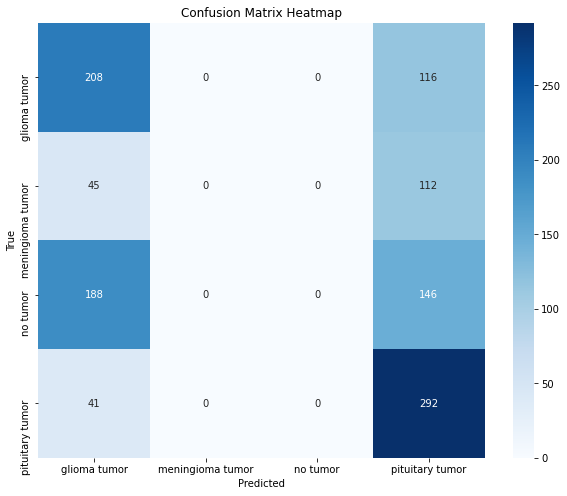

In [31]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification Report

In [32]:
model_1_LeNet_pred = model_1_LeNet.predict(X_test)

In [33]:
from sklearn.metrics import classification_report

report = classification_report(y_test, np.argmax(model_1_LeNet_pred, axis=1))

print(report)

              precision    recall  f1-score   support

           0       0.29      0.27      0.28       100
           1       0.00      0.00      0.00       105
           2       0.00      0.00      0.00       115
           3       0.22      0.91      0.36        74

    accuracy                           0.24       394
   macro avg       0.13      0.29      0.16       394
weighted avg       0.12      0.24      0.14       394



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## AlexNet Model

In [35]:
model_2_Alex = Sequential([
    Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model_2_Alex.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_2_Alex.summary()

# Define a callback for early stopping
callbacks_2 = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

# Train the model
history_2 = model_2_Alex.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30,  # AlexNet was trained for 90 epochs, but you might need fewer or more depending on your dataset
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 384)      

### Plots

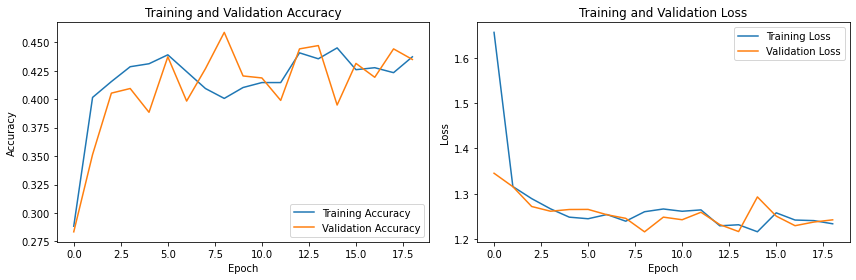

In [36]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy

In [37]:
# Predict the labels for the training set
y_train_pred_2 = model_2_Alex.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels_2 = np.argmax(y_train_pred_2, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy_2 = accuracy_score(y_train_true_labels, y_train_pred_labels_2)
print(f'Training Accuracy: {train_accuracy_2 * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred_2 = model_2_Alex.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels_2 = np.argmax(y_val_pred_2, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels_2 = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy_2 = accuracy_score(y_val_true_labels, y_val_pred_labels_2)
print(f'Validation Accuracy: {val_accuracy_2 * 100:.2f}%')

Training Accuracy: 29.01%
Validation Accuracy: 28.69%


In [38]:
# Predict the labels for the training set
y_test_pred = model_2_Alex.predict(X_test)

# Convert the predicted probabilities to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

Testing Accuracy: 18.78%


### Confusion Matrix

In [ ]:
# Generate predictions
y_pred_probs = model_2_Alex.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

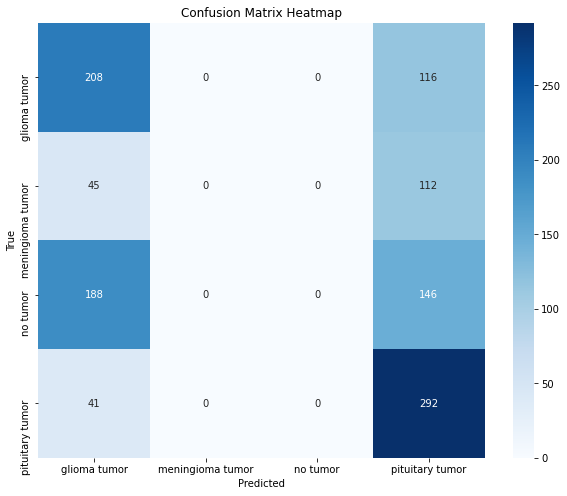

In [39]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification Report

In [40]:
from sklearn.metrics import classification_report
model_2_Alex_pred = model_2_Alex.predict(X_test)
report = classification_report(y_test, np.argmax(model_2_Alex_pred, axis=1))

print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.00      0.00      0.00       105
           2       0.00      0.00      0.00       115
           3       0.19      1.00      0.32        74

    accuracy                           0.19       394
   macro avg       0.05      0.25      0.08       394
weighted avg       0.04      0.19      0.06       394



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ResNet50

In [83]:
from keras.callbacks import LearningRateScheduler
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False
    
model1 = Sequential()
model1.add(base_model)
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(Dense(4, activation='softmax'))


# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()

history = model1.fit(X_train,y_train,epochs=20,validation_data=val_gen, callbacks=[lr_scheduler, callbacks])

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               51380736  
_________________________________________________________________
batch_normalization_766 (Bat (None, 512)               2048      
_________________________________________________________________
dense_50 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_767 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)             

### Plots

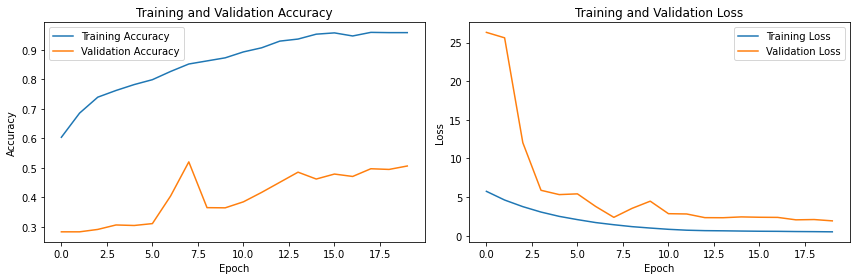

In [84]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy

In [27]:
# Predict the labels for the training set
y_train_pred = model1.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true_labels, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred = model1.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Training Accuracy: 82.40%
Validation Accuracy: 71.25%


In [85]:
# Predict the labels for the training set
y_test_pred = model1.predict(X_test)

# Convert the predicted probabilities to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

Testing Accuracy: 55.33%


### Confusion Matrix

In [88]:
# Generate predictions
y_pred_probs = model1.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

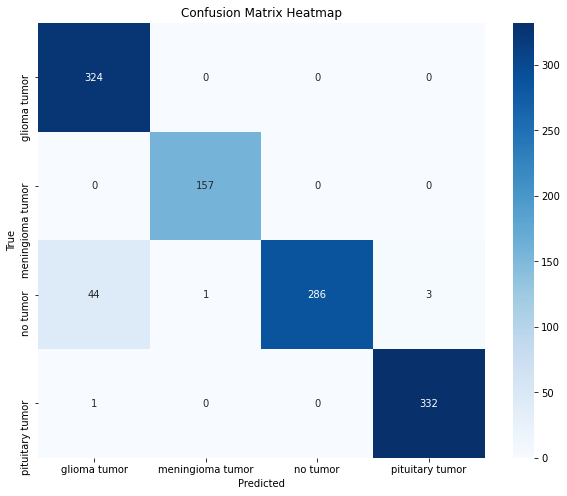

In [89]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification Report

In [86]:
model1_pred = model1.predict(X_test)

In [87]:
from sklearn.metrics import classification_report

report = classification_report(y_test, np.argmax(model1_pred, axis=1))

print(report)

              precision    recall  f1-score   support

           0       0.65      0.17      0.27       100
           1       0.43      0.94      0.59       105
           2       0.72      0.58      0.64       115
           3       0.74      0.47      0.58        74

    accuracy                           0.55       394
   macro avg       0.64      0.54      0.52       394
weighted avg       0.63      0.55      0.52       394



### Variance

In [48]:
import numpy as np

variance = np.var(model_pred, axis=0)

print("Variance for each class:", variance)

Variance for each class: [1.1186046e-06 7.1108065e-07 2.6397865e-06 2.9417943e-06]


## Inception V3

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 0.1
    return lr

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

lr_scheduler = LearningRateScheduler(lr_schedule)

# Freeze the layers of the InceptionV3 model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Create a custom model on top of the InceptionV3 base
model4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Replace num_classes with the number of classes in your dataset
])

# Compile the model
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use the appropriate loss function for your task
              metrics=['accuracy'])  # Choose metrics based on your task

# Display the model summary
model4.summary()
history = model4.fit(X_train,y_train,epochs=20, validation_data=val_gen, callbacks=[lr_scheduler, callbacks])

87916544/87910968 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 516       
Total params: 22,065,572
Trainable params: 262,980
Non-trainable params: 21,802,592
_________________________________________________________________
Epoch 1/20
36/36 [===================

### Plots

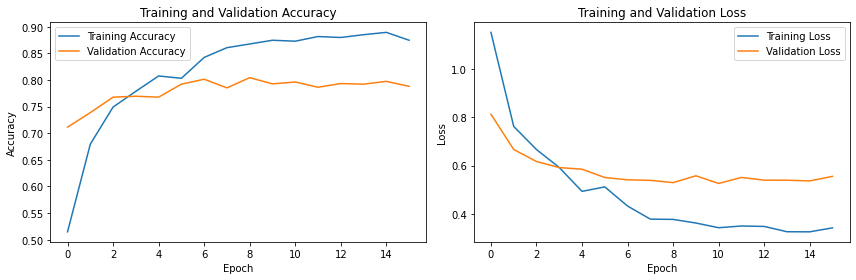

In [42]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy

In [43]:
# Predict the labels for the training set
y_train_pred = model4.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true_labels, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred = model4.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Training Accuracy: 93.29%
Validation Accuracy: 82.58%


In [44]:
# Predict the labels for the training set
y_test_pred = model4.predict(X_test)

# Convert the predicted probabilities to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

Testing Accuracy: 62.94%


### Confusion Matrix

In [45]:
# Generate predictions
y_pred_probs = model4.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

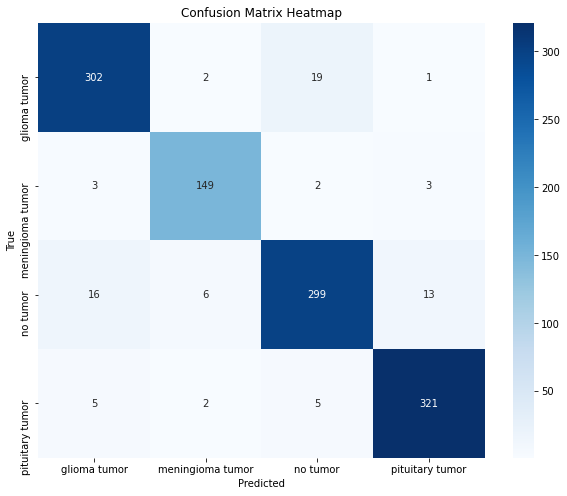

In [46]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification Report

In [43]:
model4_pred = model4.predict(X_test)

In [44]:
from sklearn.metrics import classification_report

report = classification_report(y_test, np.argmax(model4_pred, axis=1))

print(report)

              precision    recall  f1-score   support

           0       0.72      0.34      0.46       100
           1       0.56      0.89      0.69       105
           2       0.67      0.70      0.68       115
           3       0.82      0.68      0.74        74

    accuracy                           0.65       394
   macro avg       0.69      0.65      0.64       394
weighted avg       0.68      0.65      0.64       394



### Variance

In [47]:
import numpy as np

variance = np.var(model4_pred, axis=0)

print("Variance for each class:", variance)

Variance for each class: [0.05581513 0.1460838  0.08603991 0.08946791]


## DenseNet

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from keras.callbacks import LearningRateScheduler

# Define the base DenseNet model
base_model = DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the top model
top_model = models.Sequential()
top_model.add(layers.GlobalAveragePooling2D())
top_model.add(layers.Dense(256, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(layers.Dense(256, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(layers.Dropout(0.5))
top_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
top_model.add(layers.Dense(4, activation='softmax'))  # Adjust num_classes based on your problem

# Combine the base and top models
model5 = models.Sequential()
model5.add(base_model)
model5.add(top_model)

# Compile the model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model5.summary()

history = model5.fit(X_train,y_train,epochs=20,validation_data=val_gen, callbacks=[lr_scheduler, callbacks])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
sequential_10 (Sequential)   (None, 4)                 463876    
Total params: 7,501,380
Trainable params: 462,852
Non-trainable params: 7,038,528
_________________________________________________________________
Epoch 1/20
36/36 [==============================] - 28s 604ms/step - loss: 4.3251 - accuracy: 0.5482 - val_loss: 4.0694 - val_accuracy: 0.4152
Epoch 2/20
36/36 [==============================] - 19s 530ms/step - loss: 3.0968 - accuracy: 0.8059 - val_loss: 2.8256 - val_accuracy: 0.7160
Epoch 3/20
36/36 [==============================] - 18s 518ms/step - loss: 2.3512 - accuracy: 0.8747 - val_loss: 2.2036 - val_accuracy: 0.7875
Epoch 4/20
36/36 [==============================] - 18s 525ms/step - l

### Plots

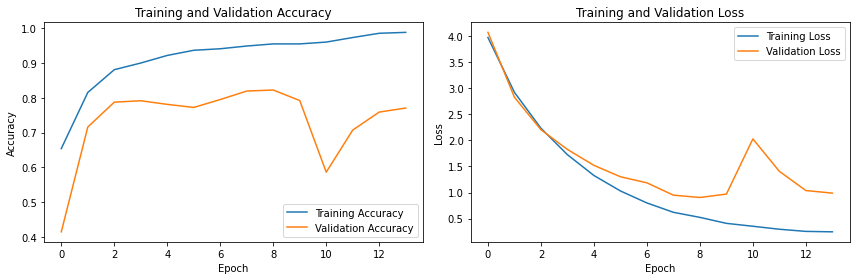

In [30]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy

In [32]:
# Predict the labels for the training set
y_train_pred = model5.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true_labels, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred = model5.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Training Accuracy: 99.65%
Validation Accuracy: 87.17%


In [33]:
# Predict the labels for the training set
y_test_pred = model5.predict(X_test)

# Convert the predicted probabilities to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

Testing Accuracy: 63.96%


### Confusion Matrix

In [ ]:
# Generate predictions
y_pred_probs = model5.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

In [ ]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification Report

In [34]:
model5_pred = model5.predict(X_test)

In [35]:
from sklearn.metrics import classification_report

report = classification_report(y_test, np.argmax(model5_pred, axis=1))

print(report)

              precision    recall  f1-score   support

           0       0.83      0.15      0.25       100
           1       0.58      0.90      0.71       105
           2       0.60      0.83      0.69       115
           3       0.89      0.64      0.74        74

    accuracy                           0.64       394
   macro avg       0.72      0.63      0.60       394
weighted avg       0.71      0.64      0.59       394



### Variance

In [49]:
import numpy as np

variance = np.var(model5_pred, axis=0)

print("Variance for each class:", variance)

Variance for each class: [0.03680437 0.19326203 0.18659353 0.10066772]


### EfficientNet

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the pre-trained EfficientNetB0 model without the top (fully connected) layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 0.1
    return lr

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True


lr_scheduler = LearningRateScheduler(lr_schedule)

# Freeze the layers of the base model
base_model.trainable = False

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

model6 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(4, activation='softmax', kernel_regularizer=regularizers.l1(0.01))
])


# Compile the model
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model6.summary()

history = model6.fit(X_train, y_train, 
                     epochs=30, 
                     validation_data=val_gen, 
                     callbacks=[lr_scheduler, callbacks])

16711680/16705208 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 1280)              5120      
_________________________________________________________________
dense_18 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 128)               512       
_______________________________________________________

### Plots

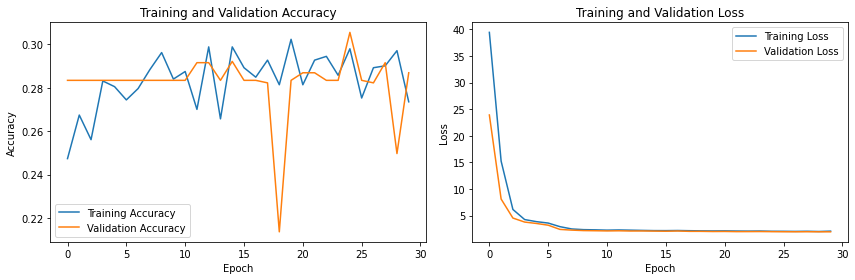

In [48]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy

In [49]:
# Predict the labels for the training set
y_train_pred = model6.predict(X_train)

# Convert the predicted probabilities to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_train_true_labels = np.argmax(y_train, axis=1)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true_labels, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Predict the labels for the validation set
y_val_pred = model6.predict(X_val)

# Convert the predicted probabilities to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to the actual class labels
y_val_true_labels = np.argmax(y_val, axis=1)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Training Accuracy: 29.01%
Validation Accuracy: 28.69%


In [23]:
# Predict the labels for the training set
y_test_pred = model6.predict(X_test)

# Convert the predicted probabilities to class labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

Testing Accuracy: 25.38%


### Confusion Matrix

In [50]:
# Generate predictions
y_pred_probs = model6.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_train, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ["glioma tumor", "meningioma tumor", "no tumor", "pituitary tumor"]  # Add your actual class labels here

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

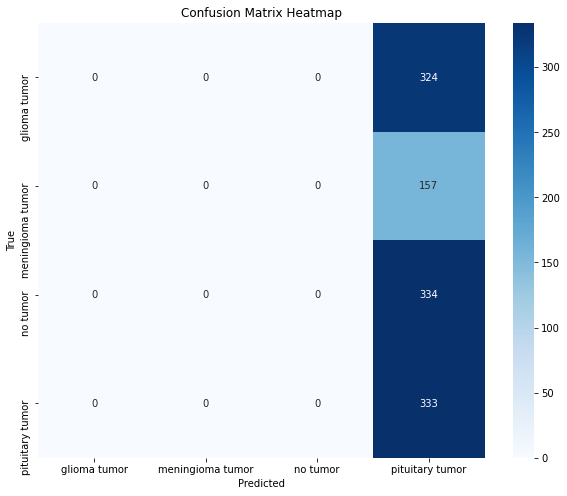

In [51]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification Report

In [26]:
from sklearn.metrics import classification_report
model_pred = model6.predict(X_test)
report = classification_report(y_test, np.argmax(model_pred, axis=1))

print(report)

              precision    recall  f1-score   support

           0       0.25      1.00      0.40       100
           1       0.00      0.00      0.00       105
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00        74

    accuracy                           0.25       394
   macro avg       0.06      0.25      0.10       394
weighted avg       0.06      0.25      0.10       394



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Variance

In [50]:
import numpy as np

variance = np.var(model5_pred, axis=0)

print("Variance for each class:", variance)

Variance for each class: [0.03680437 0.19326203 0.18659353 0.10066772]


### Ensemble Learning

In [100]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the InceptionV3 model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom model on top of the InceptionV3 base
modele2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Replace num_classes with the number of classes in your dataset
])

# Compile the model
modele2.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use the appropriate loss function for your task
              metrics=['accuracy'])  # Choose metrics based on your task

# Display the model summary
modele2.summary()
history = modele2.fit(X_train_1,y_train,epochs=20)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_16  (None, 2048)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 516       
Total params: 22,065,572
Trainable params: 262,788
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/20
72/72 [==============================] - 7s 46ms/step - loss: 1.2706 - accuracy: 0.5041
Ep

In [101]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model without the top (fully connected) layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the ResNet50 base model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom small model on top of the ResNet50 base
modele1 = models.Sequential()
modele1.add(base_model)
modele1.add(layers.Flatten())
modele1.add(layers.Dense(256, activation='relu'))
modele1.add(layers.Dropout(0.5))
modele1.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes for classification

# Compile the model
modele1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
modele1.summary()

history = modele1.fit(X_train_2,y_train,epochs=20)


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 1028      
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/20
72/72 [==============================] - 7s 58ms/step - loss: 7.4427 - accuracy: 0.3904

In [102]:
def ensemble_model(data1, data2, weight1=0.2, weight2=0.8):
    preds1 = modele2.predict(data1)
    preds2 = modele1.predict(data2)

    # Perform a weighted sum
    weighted_sum = weight1 * preds1 + weight2 * preds2

    ensemble_labels = np.argmax(weighted_sum, axis=1)
    labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
    outputs = [labels[i] for i in ensemble_labels]

    return ensemble_labels
from collections import Counter

In [103]:
ensemble_result = ensemble_model(X_val_1, X_val_2, weight1=0.7, weight2=0.3)
Counter(ensemble_result)

Counter({0: 179, 3: 177, 2: 138, 1: 80})

In [104]:
Counter(ensemble_model(X_test_1, X_test_2))

Counter({2: 160, 1: 161, 0: 23, 3: 50})

### Classification Report

In [70]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, ensemble_model(X_test_1, X_test_2))

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.95      0.19      0.32       100
           1       0.38      0.91      0.54       105
           2       0.67      0.49      0.57       115
           3       0.56      0.30      0.39        74

    accuracy                           0.49       394
   macro avg       0.64      0.47      0.45       394
weighted avg       0.65      0.49      0.46       394

